# Material de Geofísica - Obtenção de dados públicos de artigo e tratamento com Python
#### Curso de Geologia - Geofísica Aplicada - 2o Semestre 2024
Profa. Luizemara Szameitat
![Banner USP](https://raw.githubusercontent.com/lszam/geofex/main/assets/img/banner_usp.png)

OBJETIVO: Noções de harmônicos esféricos. Exercitar a construção de mapa de dados, não a partir dos valores no espaço, mas a partir de coeficientes de harmônicos esféricos.

**Dados**

Dados de gravimetria da Lua - missão GRAIL: https://pds-geosciences.wustl.edu/dataserv/gravity_models.htm , https://pds-geosciences.wustl.edu/grail/grail-l-lgrs-5-rdr-v1/grail_1001/shadr/

Referencias
* Documentação do pyshtools: pyshtools.readthedocs.io

**Anomalia Bouguer**

O dado de Anomalia Bouguer á usado em geofísica para identificar variações de massa abaixo da superfície de um corpo celeste.

Este tipo de dado nos ajuda a compreender estruturas geológicas em subsuperfície, desde estruturas de grande escala, como variações internas de planetas e luas, até escalas de afloramento, como variações associadas a falhas, depósitos minerais e reservatórios de água ou petroleo.


**Esféricos Harmônicos**

Os esféricos harmônicos são funções matemáticas utilizadas para representar e modelar padrões de variações que ocorrem sobre uma esfera. Nos métodos potenciais, são usados, por exemplo, para descrever matematicamente o campo gravitacional e o campo magnético da Terra, da Lua, ou de algum outro astro de interesse.

Quando combinadas, estas funções tem a capacidade de padrões complexos sobre a esfera. E também o inverso: podemos pegar um padrão complexo e decompor em padrões simples, para facilitar análises e processamentos específicos.


##**1. Preparar o ambiente**

In [1]:
# Blibliotecas extras
!pip install pyshtools wget -q

# Importar bibliotecas
import pyshtools as pysh
import numpy as np
import matplotlib.pyplot as plt
import wget
import os
# Sombreamento
from matplotlib.colors import LightSource, Normalize



# Função para carregar os dados dos coeficientes de harmônicos esféricos

def load_harmonic_coefficients(file_path):
    # Lê os coeficientes do arquivo fornecido com formato específico
    data = np.genfromtxt(file_path, delimiter=',', skip_header=1)

    # Número máximo de harmônicos (grau e ordem)
    max_degree = int(np.max(data[:, 0]))

    # Inicializa as matrizes C e S para os coeficientes harmônicos
    c_matrix = np.zeros((max_degree + 1, max_degree + 1))
    s_matrix = np.zeros((max_degree + 1, max_degree + 1))

    # Preenche as matrizes C e S com os coeficientes do arquivo
    for row in data:
        degree = int(row[0])
        order = int(row[1])
        c_matrix[degree, order] = row[2]
        s_matrix[degree, order] = row[3]

    return c_matrix, s_matrix, max_degree



# **2. Obter o mapa de anomalias a partir de coeficientes de esféricos harmônicos**

**Siga os seguintes passos**

1. Faça o download a partir de https://github.com/lszam/geofex/raw/refs/heads/main/data/Grav_Lua/gggrx_1200a_bouguer_sha.rar , e extraia os arquivos.

2. Faça o upload dos arquivos neste ambiente Colab.

3. Execute a célula abaixo.

In [2]:
# Caminho do arquivo com os coeficientes harmônicos esféricos
filename = 'gggrx_1200a_bouguer_sha.tab'

# Ver conteúdo do arquivo de coeficientes
coeffs = pysh.SHCoeffs.from_file(filename, lmax=1200)  # lmax é o maior grau do dado

print(coeffs)

  name = None
  kind = 'real'
  normalization = '4pi'
  csphase = 1
  lmax = 1200
  error_kind = None
  header = None
  header2 = None
  units = None


O arquivo .tab tem as colunas grau (l), ordem (m), C_lm, S_lm. Iremos gerar o mapa Bouguer a partir destes coeficientes.
A primeira linha é um tipo de metadado, e deve ser ignorada.

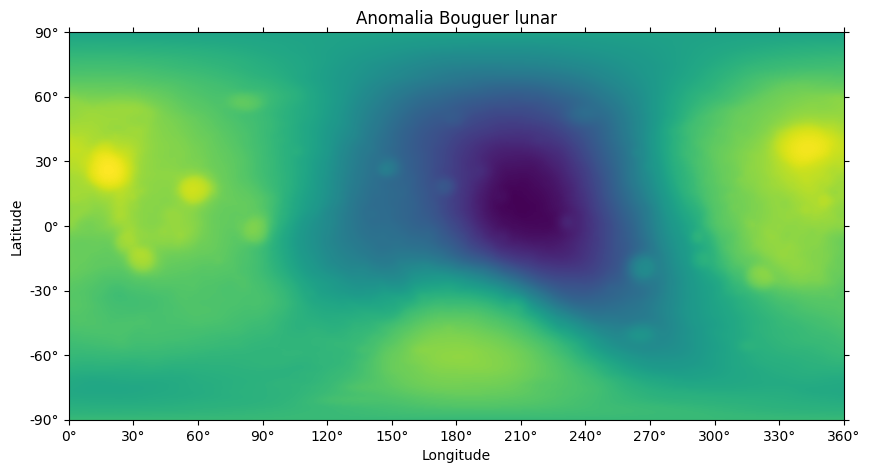

In [11]:
def load_harmonic_coefficients(filename):
    # Carrega os dados, pulando a primeira linha
    # `invalid_raise=False` para ignorar linhas com formatação errada
    data = np.genfromtxt(filename, delimiter=',', skip_header=1, usecols=(0, 1, 2, 3), invalid_raise=False)

    # Extrai as colunas: grau (l), ordem (m), C_lm, S_lm
    degrees = data[:, 0].astype(int)  # l
    orders = data[:, 1].astype(int)   # m
    c_lms = data[:, 2]                # C_lm
    s_lms = data[:, 3]                # S_lm

    # Determina o grau máximo
    max_degree = np.max(degrees)

    # Inicializa as matrizes de coeficientes com zeros
    c_matrix = np.zeros((max_degree + 1, max_degree + 1))
    s_matrix = np.zeros((max_degree + 1, max_degree + 1))

    # Popula as matrizes com os coeficientes correspondentes
    for l, m, c_lm, s_lm in zip(degrees, orders, c_lms, s_lms):
        c_matrix[l, m] = c_lm
        s_matrix[l, m] = s_lm

    return c_matrix, s_matrix, max_degree

# Nome do arquivo
filename = 'gggrx_1200a_bouguer_sha.tab'

# Carregar os coeficientes de harmônicos esféricos
c_matrix, s_matrix, max_degree = load_harmonic_coefficients(filename)

# Criar um array 3D a partir das matrizes C e S
coefficients = np.array([c_matrix, s_matrix])

# Criar um objeto de harmônicos esféricos, usando os coeficientes lidos
clm = pysh.SHCoeffs.from_array(coefficients, normalization='4pi')

# Gerar o mapa de Anomalia Bouguer
grid = clm.expand(grid='DH2')

fig, ax = plt.subplots(figsize=(10, 6))
grid.plot(ax=ax, show=False, cb_label="Anomalia de Bouguer (mGal)")
plt.title('Anomalia Bouguer lunar')
plt.show()


#**Extra - Sombreamento no mapa**

Uma técnica interessante para interpretação é o sombreamento. Ele é feito geralmente através do cálculo do efeito da iluminação vinda de uma fonte de luz específica, geralmente no topo esquerdo, determinado pela inclinação e declinação da fonte de luz, e pela inclunação e orientação das superfícies do grid iluminado.

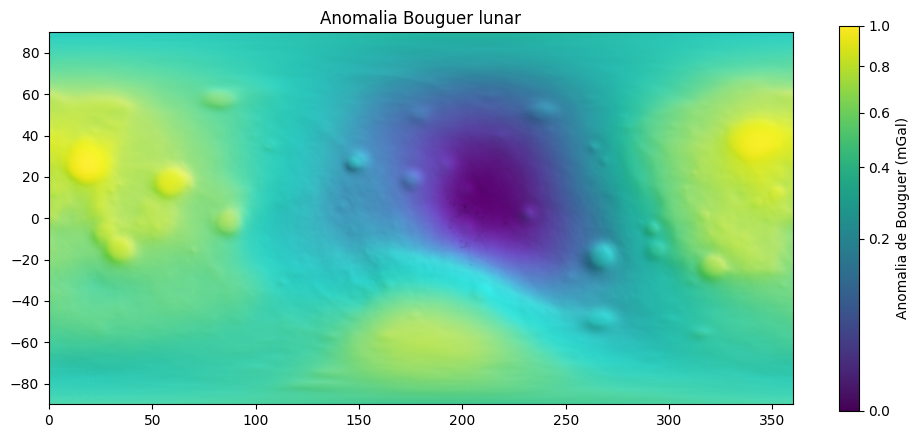

In [34]:
from matplotlib.colors import PowerNorm

# Função para calcular o hillshade

def calculate_hillshade(data, azimuth=45, altitude=45):
    # Cria um objeto LightSource
    ls = LightSource(azdeg=azimuth, altdeg=altitude)
    # Normaliza os dados entre 0 e 1, para tornar as sombras mais visíveis
    data_normalized = (data - np.min(data)) / (np.max(data) - np.min(data))
    # Aplica o hillshade
    rgb = ls.shade(data_normalized, cmap=plt.cm.viridis, vert_exag=300, blend_mode='overlay', dx=1, dy=1)
    return rgb



# Converte o grid em um array para aplicar o hillshade
data = grid.to_array()

# Calcula o hillshade preservando as cores
hillshade_rgb = calculate_hillshade(data, azimuth=45, altitude=25)

# Plota o mapa com sombreamento
fig, ax = plt.subplots(figsize=(12, 5))
#image = ax.imshow(hillshade_rgb, extent=(0, 360, -90, 90), origin='upper')
plt.imshow(hillshade_rgb, extent=(0, 360, -90, 90), origin='upper',
           cmap='viridis', aspect='equal', norm=PowerNorm(gamma=0.5))
plt.colorbar(label="Anomalia de Bouguer (mGal)")
plt.title('Anomalia Bouguer lunar')
plt.show()


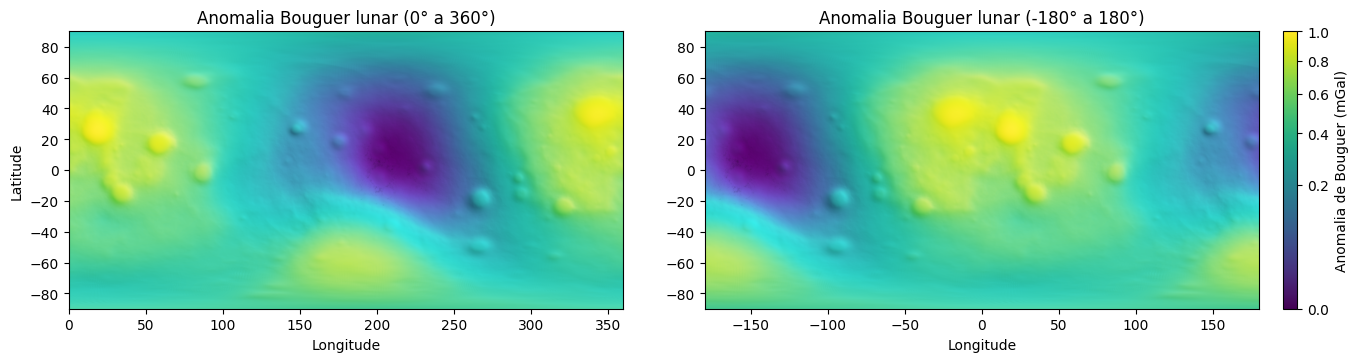

In [46]:
fig, axs = plt.subplots(1, 2, figsize=(14, 3.5))

# Mapa original (0 a 360 de longitude)
im1 = axs[0].imshow(hillshade_rgb, extent=(0, 360, -90, 90), origin='upper',
                    cmap='viridis', aspect='equal', norm=PowerNorm(gamma=0.5))
axs[0].set_title('Anomalia Bouguer lunar (0° a 360°)')
axs[0].set_xlabel('Longitude')
axs[0].set_ylabel('Latitude')

# Reorganiza os dados para a projeção de -180° a 180°
hillshade_rgb_shifted = np.roll(hillshade_rgb, shift=hillshade_rgb.shape[1] // 2, axis=1)

# Mapa modificado (-180 a 180 de longitude)
im2 = axs[1].imshow(hillshade_rgb_shifted, extent=(-180, 180, -90, 90), origin='upper',
                    cmap='viridis', aspect='equal', norm=PowerNorm(gamma=0.5))
axs[1].set_title('Anomalia Bouguer lunar (-180° a 180°)')
axs[1].set_xlabel('Longitude')


cbar = fig.colorbar(im2, ax=axs[1], orientation='vertical', fraction=0.046, pad=0.04)
cbar.set_label('Anomalia de Bouguer (mGal)')

plt.tight_layout()
plt.show()


#**PERGUNTA**
Considerando que a superfície da Lua, pelo que conhecemos, é feita por uma crosta anortosítica, e mares de derrames basálticos, o que pode significar a região de altos valores Bouguer?

In [ ]:
#
#
#
#
#
#